In [1]:
import torch
import torchvision.transforms as transforms
from utils import *
from models import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device='cpu'
print(device)

cpu


In [3]:
test_transform = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])
invertTransform = transforms.Compose([
                                transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
# test_transform = transforms.Compose([transforms.ToTensor()
# ])

test_data = torchvision.datasets.CIFAR10('data/', download=True, train=False, transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=4096, # just for test accuracy
                                          shuffle=True)

cifar_labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

Files already downloaded and verified


In [4]:
model = ResNet('50').to(device)
model.load_state_dict(torch.load('models/resnet50_l2eps=10/55')) # 20 omg
model.eval()
print()

Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


In [5]:
# test_acc = accuracy(model, test_dataloader, device)
# fgsm_acc = fgsm_accuracy(model, test_dataloader, device)
# pgd_acc = pgd_accuracy(model, test_dataloader, device, eps=10, steps=3, alpha=0.1)
# print('Normal Test Accuray:', test_acc)
# print('FGSM Test Accuracy:', fgsm_acc)
# print('PGD Test Accuracy:', pgd_acc)

In [6]:
it = iter(test_dataloader)
i, l = it.next()
images, labels = i[0:2].to(device), l[0:2].view(2).to(device)
image, label = images[0], labels[0].view(1)


In [7]:
# this cell exists because of the most annoying bug ever:
# the loss for pgd updates needed to not be averaged so that each input
# was worked on independently of the batch size

# display_im(images[0].cpu())
# print(cifar_labels[labels[0].item()])
# print(cifar_labels[torch.argmax(model(images[0].view(-1,3,32,32))).item()])
# print(torch.min(images[0]), torch.max(images[0]))
# adv = pgd(images.view(1000,3,32,32), labels, model, stepsize=2.5 * 100 / 7, eps=100, steps=7, constraint='l_2')[0]
# print(torch.min(adv), torch.max(adv))
# # adv = fgsm(image.view(1, 3, 32, 32), label, model, eps=.2)
# # print(adv.shape)
# print(torch.min(image - adv), torch.max(image - adv))
# print(cifar_labels[torch.argmax(model(adv.view(1, 3,32,32))).item()])
# display_im(adv.view(3,32,32).cpu())
# display_im((image - adv).view(3, 32, 32).cpu())

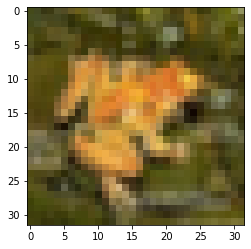

frog
frog
tensor(-1.9307) tensor(2.0777)
tensor(-1.8893) tensor(2.0799)
tensor(-0.0722) tensor(0.0789)
frog


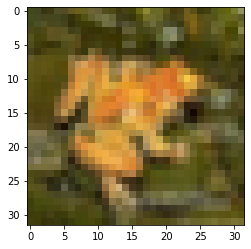

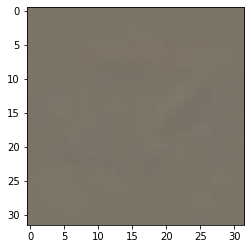

In [8]:
display_im(image.cpu())
print(cifar_labels[label.item()])
print(cifar_labels[torch.argmax(model(image.view(-1,3,32,32))).item()])
print(torch.min(image), torch.max(image))
adv = pgd(image.view(1,3,32,32), label, model, stepsize=2.5 * 10 / 7, eps=10, steps=7, constraint='l_2')
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=.015, eps=.6, steps=40, constraint='l_inf')
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=0.1, eps=.5, steps=7, constraint='l_inf')
print(torch.min(adv), torch.max(adv))
# adv = fgsm(image.view(1, 3, 32, 32), label, model, eps=.2)
# adv = pgd_attack(image.view(3,32,32), 5, model, stepsize=1, eps=60, steps=80, constraint='l_2')
# print(torch.max(image - adv))
# print(adv.shape)
print(torch.min(image - adv), torch.max(image - adv))
print(cifar_labels[torch.argmax(model(adv)).item()])
display_im(adv.view(3,32,32).cpu())
display_im((image - adv).view(3, 32, 32).cpu())

## Sketch Completion

Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


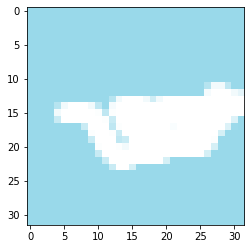

torch.Size([1, 3, 32, 32]) torch.Size([1])


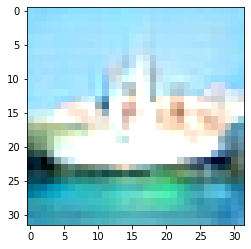

airplane


In [13]:
import imageio
from torchvision.utils import save_image
model = ResNet('18').to(device)
model.load_state_dict(torch.load('models/resnet18_l2eps=50/95'))
model.eval()
image = torch.Tensor(imageio.imread('sketch1.png')).permute(2, 0, 1).to(device) / 255.
# print(image.shape)
plt.imshow(image.permute(1, 2, 0).cpu())
plt.show()
label = torch.Tensor([6]).to(device).long()
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=1, eps=60, steps=80, constraint='l_2')
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=.015, eps=.6, steps=40, constraint='l_inf')
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=.03, eps=.1, steps=5, constraint='l_inf')
eps=5000
steps=100
# adv = fgsm(image.view(1, 3, 32, 32), label, model, eps=0.2)
adv = pgd_attack(image.view(3,32,32), 8, model, stepsize=2.5 * eps / steps, eps=eps, steps=steps, constraint='l_2')
plt.imshow(adv.cpu().view(3, 32, 32).permute(1, 2, 0))
plt.show()
print(cifar_labels[torch.argmax(model(adv.view(1, 3, 32, 32))).item()])
upsample = transforms.Compose([transforms.ToPILImage(), transforms.Resize(480, interpolation=2), transforms.ToTensor()])

torchvision.utils.save_image(upsample(adv.cpu()), 'saved.png')


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
0


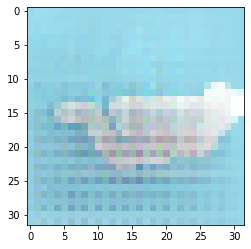

cat


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
5


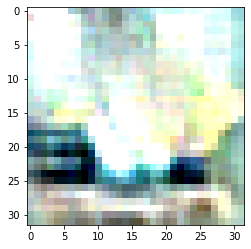

ship


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
10


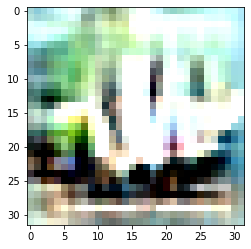

airplane


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
15


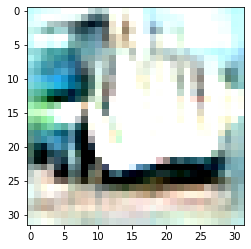

bird


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
20


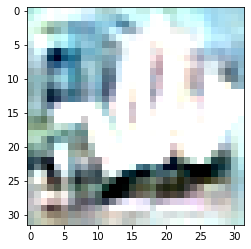

ship


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
25


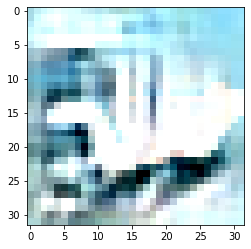

airplane


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
30


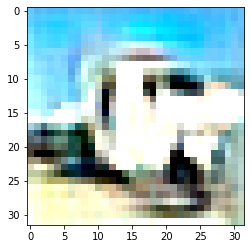

bird


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
35


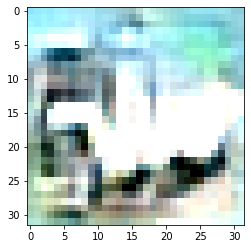

ship


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
40


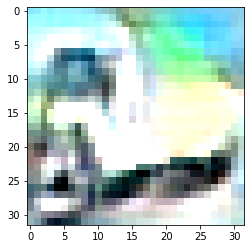

airplane


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
45


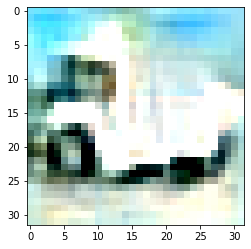

airplane


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
50


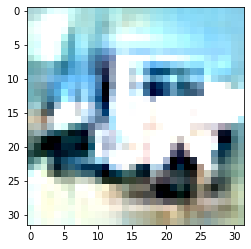

airplane


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
55


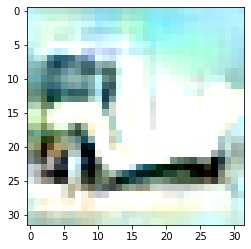

airplane


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
60


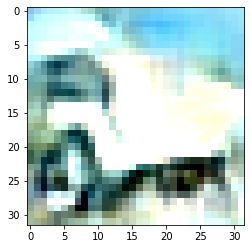

airplane


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
65


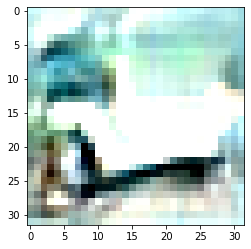

bird


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
70


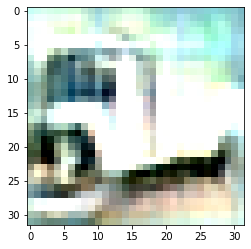

airplane


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
75


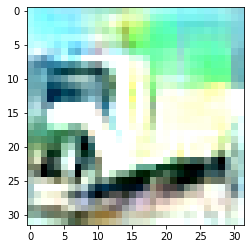

bird


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
80


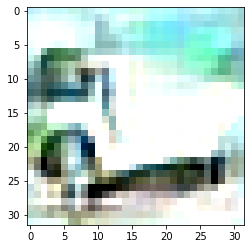

airplane


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
85


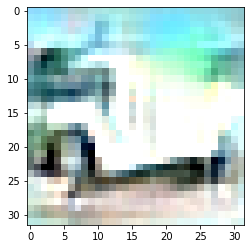

bird


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
90


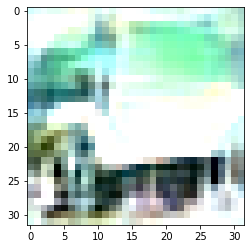

bird


Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])
95


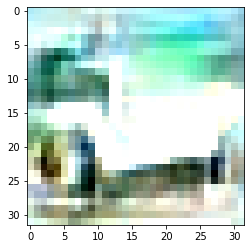

bird


In [179]:
for i in range(0,100,5):
    model = ResNet('18').to(device)
    model.load_state_dict(torch.load('models/resnet18_l2eps=50/' + str(i))) # 20 omg
    model.eval()
    eps=5000
    c = 9
    adv = pgd_attack(image.view(3,32,32), c, model, stepsize=2.5 * eps / 100, eps=eps, steps=100, constraint='l_2')
    print(i)
    plt.imshow(adv.cpu().view(3, 32, 32).permute(1, 2, 0))
    plt.show()
    print(cifar_labels[torch.argmax(model(adv.view(1, 3, 32, 32))).item()])
    


## Generation

In [20]:
train_data = torchvision.datasets.CIFAR10('data/', download=True, train=True, transform=test_transform)
train_dataloader = torch.utils.data.DataLoader(train_data,
                                          batch_size=4096, # just for test accuracy
                                          shuffle=False)
images, labels = remove_dataloader(train_dataloader)


Files already downloaded and verified


In [33]:
def remove_dataloader(dataloader):
    base_images, base_labels = [], []
    for batch in dataloader:
        images, labels = batch[0], batch[1]
        base_images.append(images)
        base_labels.append(labels)
        
    return torch.cat(base_images), torch.cat(base_labels)

def include(labels, c):
    included = []
    for i in range(len(labels)):
        if labels[i] == c:
            included.append(i)
    return included

def class_gaussians(images, labels, classes):
    means = []
    covariance = []
    
    for c in range(classes):
        included = include(labels, c)
        class_images = images[included].view(len(included), -1)
        
        means.append(torch.mean(class_images, dim=0))
        covariance.append(((class_images - means[-1]).T @ (class_images - means[-1]) + 0.001 * torch.eye(len(means[-1]))) / len(means[-1]))

    return means, covariance

def generate_conditionals(n, c, images, labels, classes):
    means, covariance = class_gaussians(images, labels, classes)
    m = torch.distributions.multivariate_normal.MultivariateNormal(means[c], covariance[c])
    return m.sample((n, )).view(-1, 3, 32, 32)
invertTransform = transforms.Compose([
                                transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

im = generate_conditionals(10, 8, images, labels, 10)
# im = generate_from_prior(train_dataloader, 1)
# print(im.shape)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


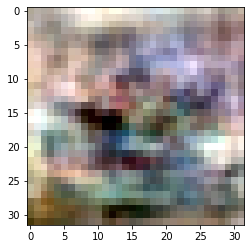

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


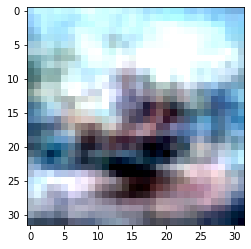

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


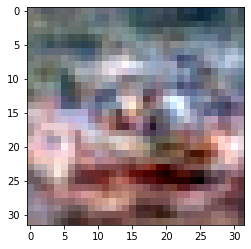

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


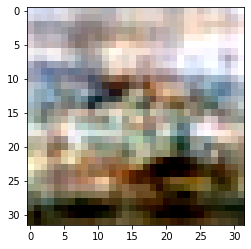

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


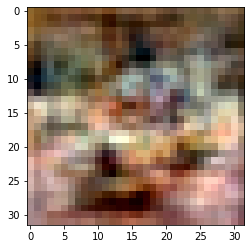

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


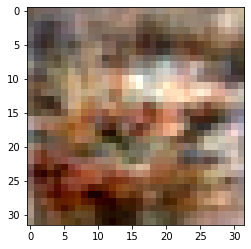

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


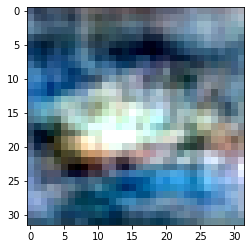

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


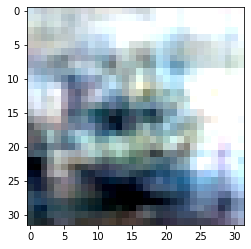

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


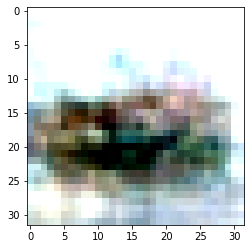

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


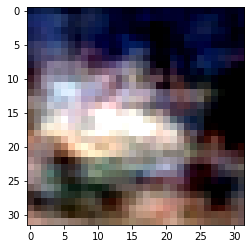

In [34]:
# print(im)
for i in range(len(im)):
    display_im(im[i].view(3,32,32))

Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])


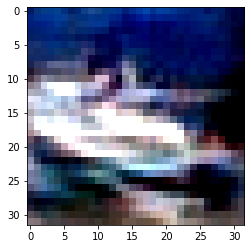

In [46]:
model = ResNet('18').to(device)
model.load_state_dict(torch.load('models/resnet18_l2eps=50/95'))
model.eval()
c = 8
# image = torch.Tensor(imageio.imread('output.png')).permute(2, 0, 1).to(device) / 255.
ima = invertTransform(im[9].view(3,32,32))
eps = 5000
steps = 100
adv = pgd_attack(ima.to(device), c, model, stepsize=2.5 * eps / steps, eps=eps, steps=steps, constraint='l_2').cpu()
plt.imshow(adv.cpu().view(3, 32, 32).permute(1, 2, 0))
plt.show()

Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


torch.Size([1, 3, 32, 32]) torch.Size([1])


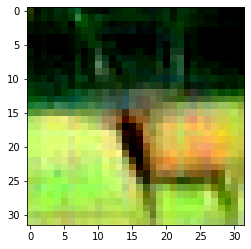

In [482]:
model = ResNet('18').to(device)
model.load_state_dict(torch.load('models/resnet18_l2eps=50/75'))
model.eval()
# image = torch.Tensor(imageio.imread('output.png')).permute(2, 0, 1).to(device) / 255.
ima = invertTransform(im[6].view(3,32,32))
eps = 5000
steps = 100
adv = pgd_attack(ima.to(device), c, model, stepsize=2.5 * eps / steps, eps=eps, steps=steps, constraint='l_2').cpu()
plt.imshow(adv.cpu().view(3, 32, 32).permute(1, 2, 0))
plt.show()